# Patient Segmentation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from lib import data, metadata

pd.options.display.max_columns = None
sns.set()

In [2]:
df = data.read_train_data()
# df = data.parse_data('data/', 'Study_D.csv')
baseline = df[df.VisitDay == 0].filter(regex="(P|N|G)\d+")

# Standardize the inputs
baseline = pd.DataFrame(
    StandardScaler().fit_transform(baseline),
    columns=baseline.columns,
    index=baseline.index,
)
baseline.head()

,P1,P2,P3,P4,P5,P6,P7,N1,N2,N3,N4,N5,N6,N7,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16
AssessmentiD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100679,0.767458,1.24658,0.88305,0.460568,1.289626,0.822112,0.688224,0.532336,0.469524,-0.017359,0.367484,0.235013,-0.043412,-0.933514,0.589266,0.700381,1.707245,1.247251,-1.197675,1.194421,-1.280023,0.747782,1.195577,0.709740,0.085072,0.255937,0.054654,0.603546,-0.081025,1.405545
100597,0.767458,1.24658,0.88305,-1.377181,-0.189606,0.822112,0.688224,-0.406084,0.469524,-1.941069,-0.592779,0.235013,-1.764347,0.065129,-1.077359,0.700381,-0.862053,0.299667,-1.197675,0.394421,-1.280023,-1.055474,1.195577,-0.229135,-1.938402,-0.574922,0.054654,0.603546,-0.081025,1.405545
101799,0.767458,1.24658,0.88305,0.460568,1.289626,0.822112,-0.215812,0.532336,0.469524,-0.017359,-0.592779,0.235013,-0.043412,-0.933514,-1.077359,-0.131748,-0.862053,-0.647917,-1.197675,0.394421,1.467874,-0.153846,1.195577,0.709740,0.085072,0.255937,0.054654,0.603546,-0.081025,0.518713
101826,0.767458,1.24658,0.88305,-0.458306,0.550010,0.822112,-1.119847,0.532336,0.469524,-0.017359,0.367484,0.235013,1.677524,0.065129,0.589266,-1.796007,0.850812,-1.595502,-1.197675,1.194421,1.467874,-1.055474,1.195577,-1.168009,0.085072,-0.574922,0.054654,-1.250828,0.842059,0.518713
101530,0.767458,1.24658,0.88305,-1.377181,-0.189606,0.822112,0.688224,0.532336,-0.582590,-0.017359,-0.592779,0.235013,-0.043412,1.063772,-0.244046,1.532511,-0.862053,1.247251,0.664526,-1.205577,0.551909,0.747782,1.195577,-0.229135,0.085072,-0.574922,0.054654,0.603546,-0.081025,0.518713


## K-means without PCA

In [36]:
from sklearn.cluster import KMeans

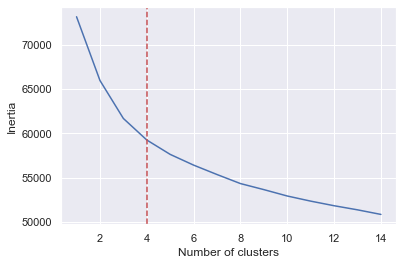

In [73]:
# Find the optimal number of clusters

inertias = []
for num_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=num_clusters).fit(baseline)
    inertias.append((num_clusters, kmeans.inertia_))
    
sns.lineplot(data=pd.DataFrame(inertias, columns=["num_clusters", "inertia"]), x="num_clusters", y="inertia")
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.axvline(x=4, color='r', linestyle="dashed")

In [88]:
num_clusters = 4
clustering = KMeans(num_clusters, random_state=0).fit(baseline)

df = baseline.copy()
df['cluster'] = pd.Categorical(clustering.labels_).astype(str)
df = df.rename(columns=metadata.COLUMN_MEANINGS)

In [89]:
df.groupby('cluster').agg('mean').apply(lambda x: pd.Series(x.nlargest(3).index), axis=1)

,0,1,2
cluster,,,
0,Unusual thought content,Suspiciousness/persecution,Hallucinatory behavior
1,Excitement,Poor impulse control,Hostility
2,Poor rapport,Uncooperativeness,Lack of spontaneity & flow of conversation
3,Motor retardation,Blunted affect,Lack of spontaneity & flow of conversation


## PCA

In [3]:
pca = PCA().fit(baseline)
pca.explained_variance_

array([4.41602397, 4.05805847, 2.55172195, 1.79571217, 1.64862908,
       1.25670896, 1.04651374, 0.91022955, 0.86637071, 0.83564697,
       0.81536979, 0.77334844, 0.72132946, 0.68508818, 0.67405104,
       0.61958658, 0.59889918, 0.58754569, 0.56553952, 0.54612703,
       0.52614968, 0.49722658, 0.47724555, 0.44514321, 0.42571059,
       0.37641688, 0.36658462, 0.3383437 , 0.30182354, 0.28516538])

In [4]:
np.cumsum(pca.explained_variance_ratio_)

array([0.14714042, 0.28235355, 0.36737606, 0.42720858, 0.48214035,
       0.52401346, 0.55888295, 0.58921149, 0.61807866, 0.64592214,
       0.67308998, 0.69885769, 0.72289214, 0.74571905, 0.7681782 ,
       0.78882262, 0.80877773, 0.82835456, 0.84719814, 0.86539491,
       0.88292604, 0.89949346, 0.91539512, 0.93022714, 0.94441167,
       0.95695376, 0.96916823, 0.98044173, 0.99049839, 1.        ])

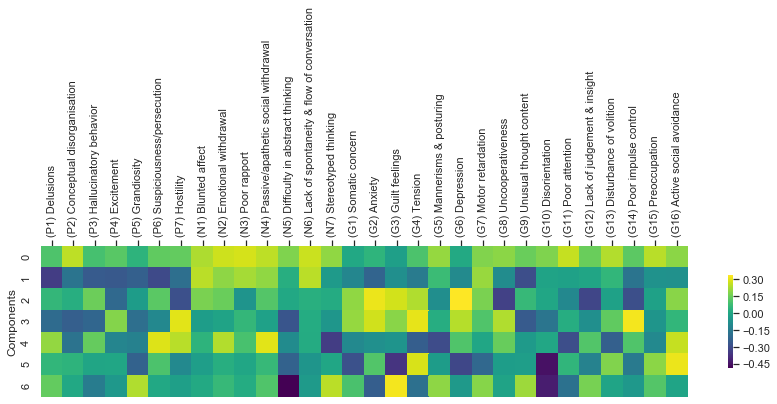

In [136]:
pca = PCA(n_components=7).fit(baseline)
pca_components_df = (
    pd.DataFrame(pca.components_, columns=baseline.columns)
    .rename(columns={k: f"({k}) {v}" for k, v in metadata.COLUMN_MEANINGS.items()})
)

f, ax = plt.subplots(figsize=(12, 7))
ax.xaxis.set_ticks_position('top')
sns.heatmap(pca_components_df, cmap="viridis", square=True, cbar_kws={"shrink": .25})
plt.ylabel('Components')
plt.tight_layout()

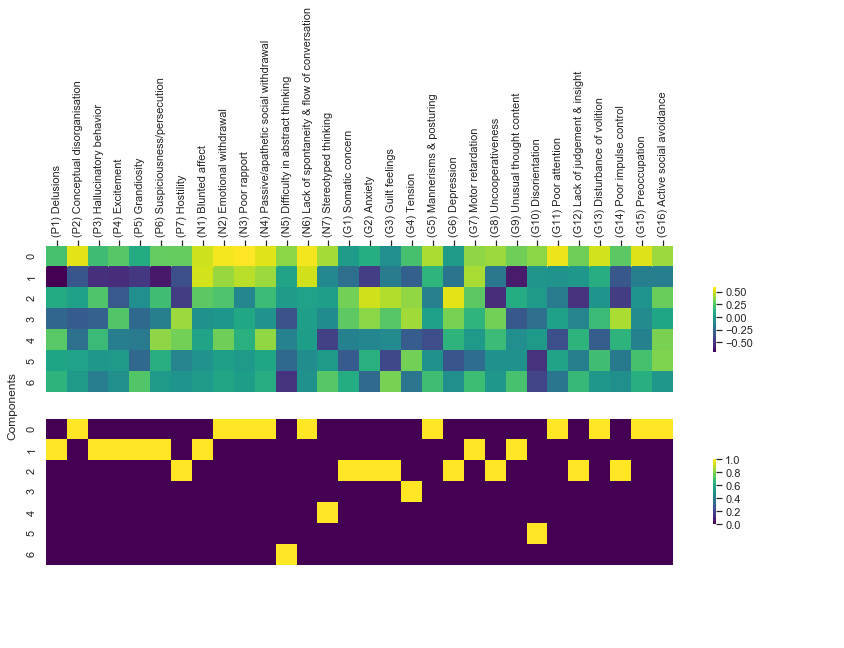

In [154]:
loadings_df = (pca_components_df.T * np.sqrt(pca.explained_variance_)).T

abs_df = loadings_df.abs()
f, axes = plt.subplots(2, 1, figsize=(12, 9))

axes[0].xaxis.set_ticks_position('top')
sns.heatmap(loadings_df, cmap="viridis", square=True, cbar_kws={"shrink": .25}, ax=axes[0])

sns.heatmap(
    abs_df == abs_df.max(axis=0),
    cmap="viridis",
    square=True,
    cbar_kws={"shrink": .25},
    ax=axes[1],
)
axes[1].get_xaxis().set_visible(False)

f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('Components')
plt.tight_layout()

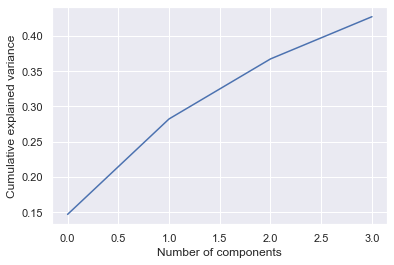

In [135]:
ev_ratios = pca.explained_variance_ratio_

plt.plot(np.cumsum(ev_ratios))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

# sns.distplot(
#     ev_ratios,
#     bins=len(ev_ratios),
#     hist_kws={'cumulative': True},
#     kde_kws={'cumulative': True},
# )

In [16]:
baseline_pca = pd.DataFrame(PCA(n_components=5).fit_transform(baseline), index=baseline.index)
baseline_pca.head()

,0,1,2,3,4
AssessmentiD,,,,,
100679,1.489910,-2.805112,1.410964,0.425652,1.257061
100597,-1.296002,-2.501326,1.148701,-1.343472,1.493379
101799,1.081963,-1.172164,0.118601,-1.624193,1.162673
101826,0.883000,0.460694,2.193148,-2.330210,0.765536
101530,1.400797,-1.513232,0.401834,-0.277268,-0.536418


## K-means clustering

In [155]:
from sklearn.cluster import KMeans

In [156]:
# Find the optimal number of clusters

inertias = []
for num_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=num_clusters).fit(baseline_pca)
    inertias.append((num_clusters, kmeans.inertia_))

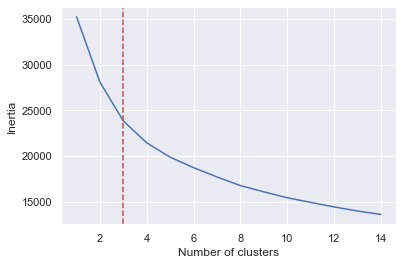

In [157]:
sns.lineplot(data=pd.DataFrame(inertias, columns=["num_clusters", "inertia"]), x="num_clusters", y="inertia")
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.axvline(x=3, color='r', linestyle="dashed")

In [162]:
clustering = KMeans(n_clusters=3).fit(baseline_pca)

df = baseline_pca.copy()
df['cluster'] = pd.Categorical(clustering.labels_).astype(str)

In [163]:
df.head()

,0,1,2,3,4,cluster
AssessmentiD,,,,,,
100679,1.489910,-2.805112,1.410964,0.425652,1.257061,1
100597,-1.296002,-2.501326,1.148701,-1.343472,1.493379,2
101799,1.081963,-1.172164,0.118601,-1.624193,1.162673,1
101826,0.883000,0.460694,2.193148,-2.330210,0.765536,1
101530,1.400797,-1.513232,0.401834,-0.277268,-0.536418,1


In [164]:
df.groupby('cluster').agg('mean')

,0,1,2,3,4
cluster,,,,,
0,-0.796758,1.806442,0.198923,0.035544,-0.085055
1,2.431090,-0.406303,0.088871,0.040344,0.031351
2,-1.334890,-1.530921,-0.287852,-0.073272,0.061174


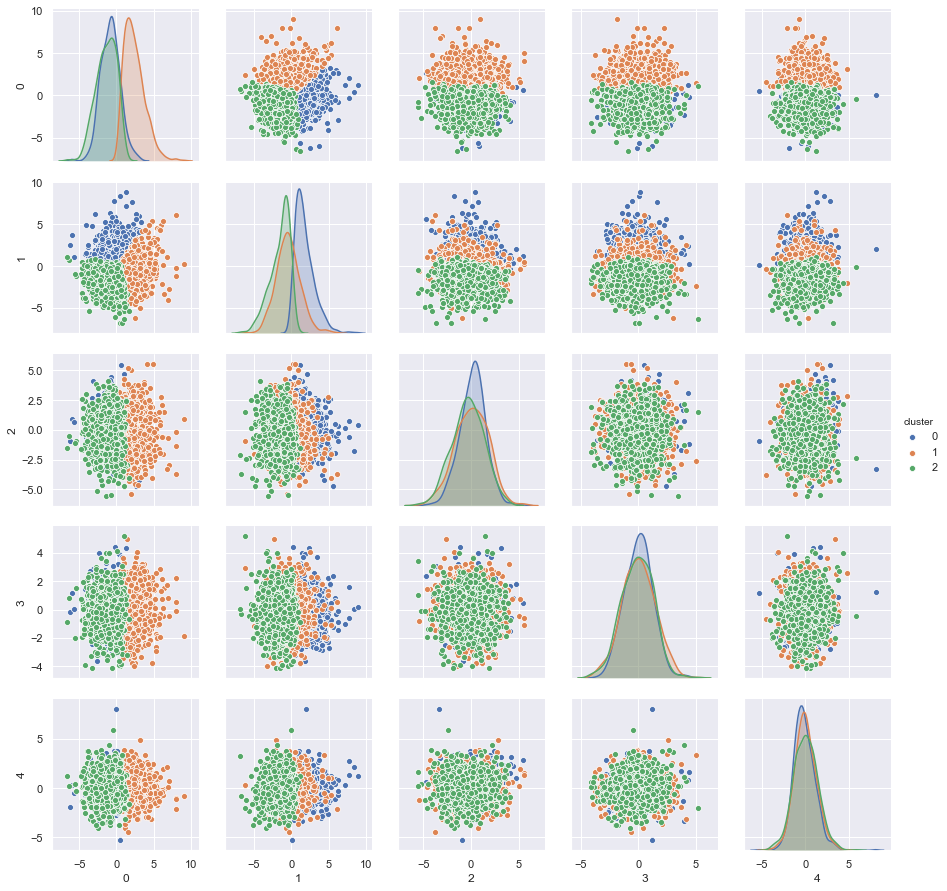

In [165]:
sns.pairplot(df, hue="cluster", vars=range(5))

## Agglomerative clustering

In [223]:
from sklearn.cluster import AgglomerativeClustering

In [6]:
clustering = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(baseline)
clustering.labels_

array([0, 0, 0, ..., 1, 0, 2])

In [7]:
df = baseline.copy()
df['cluster'] = clustering.labels_
clusters = df.groupby(['cluster'])

In [8]:
clusters.agg(['mean'])

,P1,P2,P3,P4,P5,P6,P7,N1,N2,N3,N4,N5,N6,N7,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.994881,4.626280,4.991468,2.945392,2.962457,5.061433,2.655290,3.587031,3.849829,3.105802,3.887372,4.022184,3.172355,3.194539,2.585324,3.795222,2.211604,3.087031,2.372014,2.858362,2.414676,2.412969,4.616041,2.568259,3.240614,3.728669,3.201365,2.626280,3.554608,4.037543
1,4.621253,3.283379,3.465940,3.038147,2.681199,4.158038,2.746594,2.528610,2.855586,2.506812,2.896458,3.468665,2.239782,2.771117,2.087193,2.738420,1.820163,2.275204,1.910082,1.945504,1.662125,2.482289,3.713896,2.065395,2.708447,4.386921,2.427793,2.722071,2.839237,2.904632
2,3.399050,3.546318,2.859857,2.254157,1.733967,3.465558,2.323040,4.102138,4.057007,3.809976,4.182898,4.216152,3.997625,2.997625,1.855107,2.422803,1.420428,2.304038,2.793349,1.947743,2.997625,2.548694,2.914489,2.724466,3.330166,4.187648,3.375297,2.444181,3.382423,3.515439
3,4.106858,2.928230,4.031898,2.220096,2.020734,3.988836,1.810207,3.333333,3.457735,2.746411,3.540670,3.494418,2.776715,2.810207,2.389155,3.421053,2.266348,2.822967,2.073365,2.875598,2.314195,1.690590,3.154705,2.015949,2.582137,3.180223,2.754386,2.015949,2.874003,3.374801
4,2.958810,2.929062,2.011442,2.082380,1.794050,3.057208,1.787185,3.482838,3.395881,2.956522,3.425629,3.409611,3.048055,2.842105,2.356979,2.988558,2.080092,2.652174,2.304348,2.517162,2.533181,1.908467,2.544622,1.823799,2.734554,3.315789,2.883295,2.050343,2.693364,2.970252


## T-SNE

In [215]:
from sklearn.manifold import TSNE

In [220]:
embedded = TSNE().fit_transform(baseline)

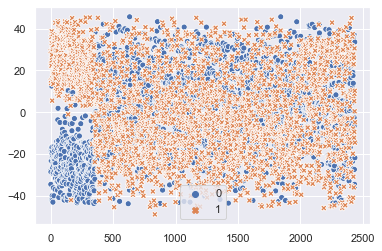

In [221]:
sns.scatterplot(data=embedded)